## Load Packages

In [2]:
%pylab inline
import scipy
import h5py
import skimage
from skimage import io,transform 
from collections import OrderedDict
home = '/home/gatys/'
project_dir = home + 'NeuralImageSynthesis/'
photo_dir = project_dir + '/Images/Photos/'
art_dir = project_dir + '/Images/Paintings/'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Define Python helper functions - should move to python packge

In [3]:
def make_torch_input(filename, layers, loss_functions, args):
    f = h5py.File(filename,'w')
    for l,layer in enumerate(layers):
        layer_group = f.create_group(layer)
        for lf,loss_function in enumerate(loss_functions[l]):
            lf_group = layer_group.create_group(loss_function)
            for arg in args[l][lf]:
                dataset = lf_group.create_dataset(arg, data=args[l][lf][arg])
    f.close()
def make_torch_aesth_input(filename, layers, args):
    f = h5py.File(filename,'w')
    for l,layer in enumerate(layers):
        layer_group = f.create_group(layer)
        for arg in args[l]:
            dataset = layer_group.create_dataset(arg, data=args[l][arg])
    f.close()

    
def make_torch_init(filename, init):
    f = h5py.File(filename,'w')
    f.create_dataset('init', data=init)
    f.close()

def get_torch_output(filename):
    f = h5py.File(filename,'r')
    data = f['opt_result']
    return data.value
    f.close()
def get_torch_loss(filename):
    f = h5py.File(filename,'r')
    data = f['losses']
    return data.value
    f.close()

def list2css(layers):
    '''
    Takes list of strings and returns comma separated string
    '''
    css = str()
    for l in layers:
        css = css+l+','
    return css[:-1]

def get_activations(images, caffe_model, layers='all', gpu=0):
    '''
    Function to get neural network activations in response to images from torch.
    
    :param images: array of images
    :param caffe_model: file name of the network .caffemodel file
    :param layers: network layers for which the activations should be computed
    :return: network activations in response to images
    '''
    layers = list2css(layers)
    tmp_dir = project_dir + 'Tmp/'
    images_file_name = tmp_dir + 'images.hdf5'
    output_file_name = tmp_dir + 'activations.hdf5'
    f = h5py.File(images_file_name, 'w')
    f.create_dataset('images', data=images)
    f.close()
    context = {
    'caffe_model': caffe_model,
    'images': images_file_name,
    'layers': layers,
    'gpu': gpu,
    'backend': 'cudnn',
    'output_file': output_file_name
    }

    template = ('#!/bin/bash\n' +
                '/usr/local/torch/install/bin/th ComputeActivations.lua ' + 
                '-caffe_model {caffe_model} ' +
                '-images {images} ' + 
                '-layers {layers} ' + 
                '-gpu {gpu} ' + 
                '-backend {backend} ' +
                '-output_file {output_file}')

    script_name = project_dir + 'get_activations.sh'
    with open(script_name, 'w') as script:
        script.write(template.format(**context))
    #execute script PATH NEEDS TO BE CHANGED ON NEW MACHINE
    !cd /home/gatys/NeuralImageSynthesis/ && \
    ./get_activations.sh >/dev/null
    
    f = h5py.File(output_file_name,'r')
    act = OrderedDict()
    for key in f.keys():
        act[key] = f[key].value.copy()
    f.close()
    return act

def preprocess(image):
    assert(image.max() <= 1.)
    imagenet_mean = array([0.40760392,  0.45795686,  0.48501961])
    image_torch = 255 * (image[:,:,::-1] - imagenet_mean).transpose(2,0,1)
    return image_torch

def deprocess(image_torch):
    imagenet_mean = array([0.40760392,  0.45795686,  0.48501961])
    image = (image_torch.transpose(1,2,0)/255. + imagenet_mean)[:,:,::-1]
    image[image>1] = 1
    image[image<0] = 0
    return image

def gram_matrix(activations):
    n_fm = activations.shape[0]
    F = activations.reshape(n_fm,-1)
    G = F.dot(F.T) / F[0,:].size
    return G

import itertools
def flatten(l):
    return list(itertools.chain.from_iterable(l))

def set_model(name, project_dir):
    if name == 'org_pad':
        model = project_dir + 'Models/VGG_ILSVRC_19_layers_conv.caffemodel'
    elif name == 'org_nopad':
        model = project_dir + 'Models/VGG_ILSVRC_19_layers_conv_nopad.caffemodel'
    elif name == 'norm_pad':
        model = project_dir + 'Models/vgg_normalised.caffemodel'
    elif name == 'norm_nopad':
        model = project_dir + 'Models/vgg_normalised_nopad.caffemodel'
    else:
        assert False, 'unknown model name'
    return model
    
def get_patch(image, x, y, h, w):
    '''
    Returns patch from image
    x,y gives upper left corner
    h,w gives height and width
    '''
    patch = image[y:y+h,x:x+w, :].copy()
    return patch

from skimage import transform
import numpy as np
def get_rotated_patch(image, x, y, h, w, angle):
    '''
    returns patch that is rotated by angle (radians) around patch center
    '''
    tf_rotate = transform.SimilarityTransform(rotation=angle)
    tf_shift = transform.SimilarityTransform(translation=[-np.round(x+w/2), -np.round(y+h/2)])
    tf_shift_inv = transform.SimilarityTransform(translation=[np.round(x+w/2), np.round(y+h/2)])
    image_rotated = transform.warp(image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
    rotated_patch = get_patch(image_rotated, x, y, h, w)
    return rotated_patch

def match_color(target_img, source_img, mode='sym'):
   '''
   Matches the colour distribution of the target image to that of the source image
   using a linear transform.
   Images are expected to be of form (w,h,c).
   Modes are chol, pca or sym for different choices of basis.
   '''
   mu_t = target_img.mean(0).mean(0)
   t = target_img - mu_t
   t = t.transpose(2,0,1).reshape(3,-1)
   Ct = t.dot(t.T) / t.shape[1]
   mu_s = source_img.mean(0).mean(0)
   s = source_img - mu_s
   s = s.transpose(2,0,1).reshape(3,-1)
   Cs = s.dot(s.T) / s.shape[1]
   if mode == 'chol':
       chol_t = np.linalg.cholesky(Ct)
       chol_s = np.linalg.cholesky(Cs)
       ts = chol_s.dot(np.linalg.inv(chol_t)).dot(t)
   if mode == 'pca':
       eva_t, eve_t = np.linalg.eigh(Ct)
       Qt = eve_t.dot(np.sqrt(np.diag(eva_t))).dot(eve_t.T)
       eva_s, eve_s = np.linalg.eigh(Cs)
       Qs = eve_s.dot(np.sqrt(np.diag(eva_s))).dot(eve_s.T)
       ts = Qs.dot(np.linalg.inv(Qt)).dot(t)
   if mode == 'sym':
       eva_t, eve_t = np.linalg.eigh(Ct)
       Qt = eve_t.dot(np.sqrt(np.diag(eva_t))).dot(eve_t.T)
       Qt_Cs_Qt = Qt.dot(Cs).dot(Qt)
       eva_QtCsQt, eve_QtCsQt = np.linalg.eigh(Qt_Cs_Qt)
       QtCsQt = eve_QtCsQt.dot(np.sqrt(np.diag(eva_QtCsQt))).dot(eve_QtCsQt.T)
       ts = np.linalg.inv(Qt).dot(QtCsQt).dot(np.linalg.inv(Qt)).dot(t)
   matched_img = ts.reshape(*target_img.transpose(2,0,1).shape).transpose(1,2,0)
   matched_img += mu_s
   matched_img[matched_img>1] = 1
   matched_img[matched_img<0] = 0
   return matched_img

def lum_transform(image):
    img = image.transpose(2,0,1).reshape(3,-1)
    lum = np.array([.299, .587, .114]).dot(img).squeeze()
    img = tile(lum[None,:],(3,1)).reshape((3,image.shape[0],image.shape[1]))
    return img.transpose(1,2,0)

## Get images and apply preprocessing

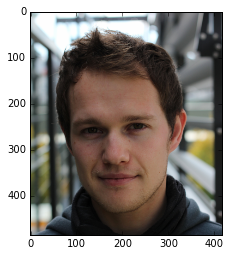

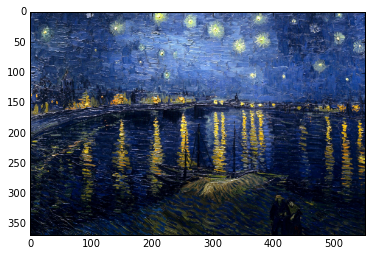

In [19]:
#get images
img_size = 450.
conditions = ['content','style']
img_names = OrderedDict()
img_names['content'] = 'leon_cropped.jpg'
img_names['style'] = 'vangogh_starry2.jpg'

# img_names['content'] = 'sig_woman.png'
# img_names['style'] = 'sig_man_painting_crop.jpg'
imgs = OrderedDict()
imgs['content'] = imread(photo_dir + img_names['content'])
try:
    imgs['content'] = transform.pyramid_reduce(imgs['content'], sqrt(float(imgs['content'][:,:,0].size) / img_size**2))
except:
    imgs['content'] = imgs['content']/255. 
imgs['style'] = imread(art_dir + img_names['style'])
try:
    imgs['style'] = transform.pyramid_reduce(imgs['style'], sqrt(float(imgs['style'][:,:,0].size) / img_size**2))
except:
    imgs['style'] = imgs['style']/255. 
imgs_torch = OrderedDict()
for cond in conditions:
    imshow(imgs[cond]);show()
    imgs_torch[cond] = preprocess(imgs[cond])

## Define and get the targets for the image synthesis

In [65]:
model_name = 'org_pad'
caffe_model = set_model(model_name, project_dir)
gpu = 0
act = OrderedDict()
input_file_name = project_dir + 'Tmp/input.hdf5'
aesth_input_file_name = project_dir + 'Tmp/aesth_input.hdf5'
init_file_name = project_dir + 'Tmp/init.hdf5'
output_file_name = project_dir + 'Tmp/output.hdf'
layers = [
    'relu1_1',
#     'relu2_1',
#     'relu3_1',
#     'relu4_1',
#     'relu4_2',
#     'relu5_1'
]
loss_functions = [
    ['GramMSE'],
#     ['GramMSE'],
#     ['GramMSE'],
#     ['GramMSE'],
#     ['MSE'],
#     ['GramMSE']
]
sw = 0
cw = 1
weights = [
    [array([sw/64**2])],
#     [array([sw/128**2])],
#     [array([sw/256**2])],
#     [array([sw/512**2])],
#     [array([cw])],    
#     [array([sw/512**2])],
]

for cond in conditions:
    act[cond] = get_activations(imgs_torch[cond],
                                caffe_model,
                                layers=layers,
                                gpu=gpu
                               )
args = [
    [
        {'targets': gram_matrix(act['style'][layers[0]])[None,:],
          'weights': weights[0][0]}
    ],
#         [
#         {'targets': gram_matrix(act['style'][layers[1]])[None,:],
#           'weights': weights[1][0]}
#     ],
#         [
#         {'targets': gram_matrix(act['style'][layers[2]])[None,:],
#           'weights': weights[2][0]}
#     ],
#         [
#         {'targets': gram_matrix(act['style'][layers[3]])[None,:],
#           'weights': weights[3][0]}
#     ],
#         [
#         {'targets': act['content'][layers[4]][None,:],
#           'weights': weights[4][0]}
#     ],
#         [
#         {'targets': gram_matrix(act['style'][layers[5]])[None,:],
#           'weights': weights[5][0]}
#         ]
]
make_torch_input(input_file_name, layers, loss_functions, args)
# make_torch_init(init_file_name, imgs_torch['content'])
make_torch_init(init_file_name, randn(*imgs_torch['content'].shape))
aesth_args = [{'weight': randn(1,64), 'bias': randn(1,1), 'strength': array([1])}]
make_torch_aesth_input(aesth_input_file_name, layers, aesth_args)

## Run image synthesis

In [ ]:
max_iter = 500
context = {
    'caffe_model': caffe_model,
    'input_file': input_file_name,
    'aesth_input': aesth_input_file_name,
    'init_file': init_file_name,
    'gpu': gpu,
    'max_iter': max_iter,
    'backend': 'cudnn',
    'print_iter': 50,
    'save_iter': 0,
    'layer_order': list2css(layers),
    'output_file': output_file_name
}

template = (
            '#!/bin/bash\n' +
            'time /usr/local/torch/install/bin/th ImageSynthesisAesthetics.lua ' + 
            '-caffe_model {caffe_model} ' +
            '-input_file {input_file} ' + 
            '-aesth_input {aesth_input} ' + 
            '-init_file {init_file} ' + 
            '-gpu {gpu} ' + 
            '-max_iter {max_iter} ' +
            '-print_iter {print_iter} ' +
            '-save_iter {save_iter} ' +
            '-backend {backend} ' + 
            '-layer_order {layer_order} ' +
            '-output_file {output_file}'
           )

script_name = project_dir + 'run_synthesis.sh'
with open(script_name, 'w') as script:
    script.write(template.format(**context))
#execute script PATH NEEDS TO BE CHANGED ON NEW MACHINE
!cd /home/gatys/NeuralImageSynthesis/ && \
./run_synthesis.sh

Successfully loaded /home/gatys/NeuralImageSynthesis/Models/VGG_ILSVRC_19_layers_conv.caffemodel
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Running optimization with L-BFGS	
<optim.lbfgs> 	creating recyclable direction/step/history buffers	
Iteration 50 / 500	
relu1_1	
GramMSE loss: 0.000000	
MeanAesth loss: -0.000000	
Total loss: -0.000000	
Iteration 100 / 500	
relu1_1	
GramMSE loss: 0.000000	
MeanAesth loss: -0.000000	
Total loss: -0.000000	
Iteration 150 / 500	
relu1_1	
GramMSE loss: 0.000000	
MeanAesth loss: -0.000000	
Total loss: -0.000000	
Iteration 200 / 500	
relu1_1	
GramMSE loss: 0.000000	
MeanAesth loss: -0.000000	
Total loss: -0.000000	
Iteration 250 / 500	
relu1_1	
GramMSE loss: 0.000000	
Mea

## Load torch output and save image

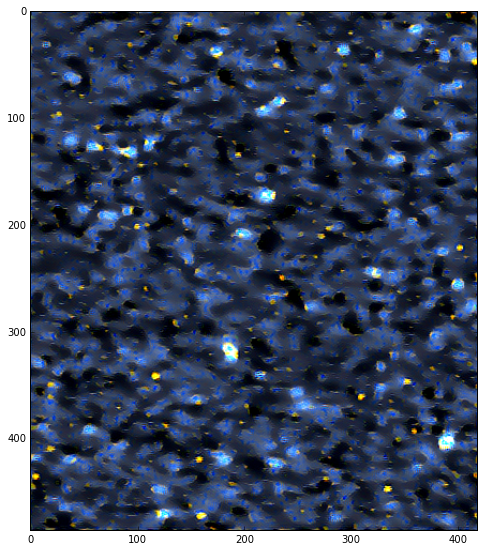

In [64]:
output = deprocess(get_torch_output(output_file_name))
imshow(output);gcf().set_size_inches(8,14)

In [ ]:
lf = list2css(map(str,loss_functions))
lf = str.replace(lf,'[','_')
lf = str.replace(lf,']','_')
# w = list2css(map(str,weights))
# w = str.replace(w,'[','_')
# w = str.replace(w,']','_')

result_image_name = (
'cimg_' + img_names['content'] + 
'_simg_' + img_names['style'] + 
'_sz_' + str(img_size) + 
'_model_' + model_name + 
'_layers_' + list2css(layers) + 
'_lf_' + lf +
# '_weights_' + w + 
'.jpg'
)
imsave(project_dir + 'Results/Images/' + result_image_name, output)